In [504]:
import numpy as np
import pandas as pd

import seaborn as sns
import os

'''for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))'''

/kaggle/input/Glass_Quality_Participants_Data/Test.csv
/kaggle/input/Glass_Quality_Participants_Data/Sample_Submission.xlsx
/kaggle/input/Glass_Quality_Participants_Data/Train.csv


In [505]:
data = pd.read_csv('/kaggle/input/Glass_Quality_Participants_Data/Train.csv')
test = pd.read_csv('/kaggle/input/Glass_Quality_Participants_Data/Test.csv')
SUBMISSION = pd.read_excel('/kaggle/input/Glass_Quality_Participants_Data/Sample_Submission.xlsx')
data.head()

,grade_A_Component_1,grade_A_Component_2,max_luminosity,thickness,xmin,xmax,ymin,ymax,pixel_area,log_area,x_component_1,x_component_2,x_component_3,x_component_4,x_component_5,class
0,0,1,150,36,144,172,947225,947332,439,439.099273,0,0,1,0,0,1
1,1,0,134,55,1144,1152,2379058,2379624,329,329.205616,1,0,0,0,0,1
2,1,0,135,65,950,974,1038442,1036754,300,300.120598,0,0,0,0,0,2
3,0,1,123,35,41,220,1705580,1705604,6803,6803.778622,0,0,1,0,0,1
4,1,0,138,69,462,466,1088124,1086579,251,251.401943,0,0,0,0,0,2


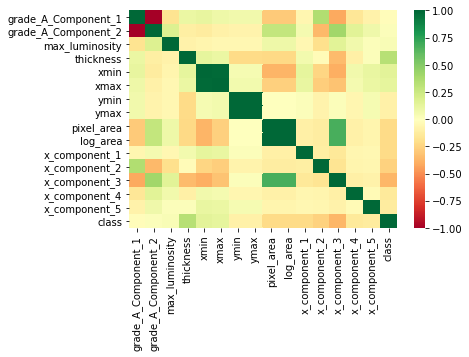

In [506]:
sns.heatmap(data.corr(), cmap = 'RdYlGn')

In [507]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.base import BaseEstimator, TransformerMixin

class ReduceVIF(BaseEstimator, TransformerMixin):
    def __init__(self, thresh=10.0, impute=True, impute_strategy='median'):
        self.thresh = thresh

    def fit(self, X, y=None):
        print('ReduceVIF fit')
        if hasattr(self, 'imputer'):
            self.imputer.fit(X)
        return self

    def transform(self, X, y=None):
        print('ReduceVIF transform')
        columns = X.columns.tolist()
        return ReduceVIF.calculate_vif(X, self.thresh)

    @staticmethod
    def calculate_vif(X, thresh=10.0):
        dropped=True
        while dropped:
            variables = X.columns
            dropped = False
            vif = [variance_inflation_factor(X[variables].values, X.columns.get_loc(var)) for var in X.columns]
            
            max_vif = max(vif)
            if max_vif > thresh:
                maxloc = vif.index(max_vif)
                print(f'Dropping {X.columns[maxloc]} with vif={max_vif}')
                X = X.drop([X.columns.tolist()[maxloc]], axis=1)
                dropped=True
        return X

In [508]:
tf = ReduceVIF()
x = tf.fit_transform(data.drop(['class'], axis = 1), data['class'])

ReduceVIF fit
ReduceVIF transform
Dropping pixel_area with vif=178151795.5153971
Dropping ymax with vif=4768035.720448821
Dropping xmin with vif=86.23671662166706
Dropping grade_A_Component_2 with vif=38.934299790778674


In [509]:
test.drop(['pixel_area', 'ymax', 'xmin', 'grade_A_Component_2'], axis = 1, inplace = True)

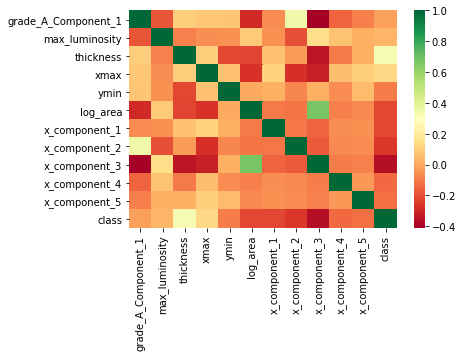

In [510]:
sns.heatmap(pd.concat([x, data['class']], axis = 1).corr(), cmap = 'RdYlGn')

In [511]:
x.head()

,grade_A_Component_1,max_luminosity,thickness,xmax,ymin,log_area,x_component_1,x_component_2,x_component_3,x_component_4,x_component_5
0,0,150,36,172,947225,439.099273,0,0,1,0,0
1,1,134,55,1152,2379058,329.205616,1,0,0,0,0
2,1,135,65,974,1038442,300.120598,0,0,0,0,0
3,0,123,35,220,1705580,6803.778622,0,0,1,0,0
4,1,138,69,466,1088124,251.401943,0,0,0,0,0


In [512]:
x['new_x'] = x[['x_component_1', 'x_component_2', 'x_component_4', 'x_component_5']].sum(axis = 1)/4
x.head()

,grade_A_Component_1,max_luminosity,thickness,xmax,ymin,log_area,x_component_1,x_component_2,x_component_3,x_component_4,x_component_5,new_x
0,0,150,36,172,947225,439.099273,0,0,1,0,0,0.00
1,1,134,55,1152,2379058,329.205616,1,0,0,0,0,0.25
2,1,135,65,974,1038442,300.120598,0,0,0,0,0,0.00
3,0,123,35,220,1705580,6803.778622,0,0,1,0,0,0.00
4,1,138,69,466,1088124,251.401943,0,0,0,0,0,0.00


In [513]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
x = pd.DataFrame(scaler.fit_transform(x), columns = x.columns)

In [514]:
x.head()

,grade_A_Component_1,max_luminosity,thickness,xmax,ymin,log_area,x_component_1,x_component_2,x_component_3,x_component_4,x_component_5,new_x
0,0.0,0.684211,-0.731707,-0.326835,-0.154234,0.136638,0.0,0.0,1.0,0.0,0.0,0.0
1,1.0,-0.157895,-0.268293,0.797018,0.666895,-0.024726,1.0,0.0,0.0,0.0,0.0,1.0
2,1.0,-0.105263,-0.024390,0.592890,-0.101922,-0.067433,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,-0.736842,-0.756098,-0.271789,0.280668,9.482279,0.0,0.0,1.0,0.0,0.0,0.0
4,1.0,0.052632,0.073171,0.010321,-0.073431,-0.138969,0.0,0.0,0.0,0.0,0.0,0.0


In [515]:
cols = x.columns

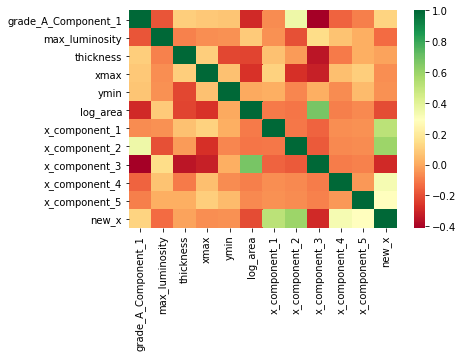

In [516]:
sns.heatmap(x.corr(), cmap = 'RdYlGn')

In [517]:
y = data['class']

In [518]:
x.shape, y.shape

((1358, 12), (1358,))

In [519]:
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier,
                              BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier)
from sklearn.linear_model import LogisticRegression

#skf = StratifiedShuffleSplit(random_state = 101)
skf = StratifiedKFold(n_splits = 5, random_state = 101, shuffle = True)

lr = LogisticRegression()
mnb = MultinomialNB()
bernoulli = BernoulliNB()
rfc = RandomForestClassifier()
ada = AdaBoostClassifier()
bag = BaggingClassifier()
etc = ExtraTreesClassifier()
gbc = GradientBoostingClassifier()
knn = KNeighborsClassifier()
xgb = XGBClassifier()
cat = CatBoostClassifier(silent = True)
lgb = LGBMClassifier()

models = [(lr, 'Logistic Regression'), (bernoulli, 'BernoulliNB'),(rfc, 'rfc'),(ada, 'ada'),
          (bag, 'Baggingclf'), (etc, 'etc'), (gbc, 'GBC'),
          (knn, 'knn'), (xgb, 'xgb'), (cat, 'cat'), (lgb, 'lgb')]

loss = {
    'Logistic Regression' : [],
    'BernoulliNB' : [],
    'rfc' : [],
    'ada' : [],
    'Baggingclf' : [],
    'etc' : [],
    'GBC' : [],
    'knn' : [],
    'xgb' : [],
    'lgb' : [],
    'cat' : []
}
smote = SMOTE()
x, y = smote.fit_sample(x, y)

for model, label in models:
    l = []
    for train_idx, test_idx in skf.split(x, y):
        x_train, x_test = x.iloc[train_idx], x.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        model.fit(x_train, y_train)
        pred = model.predict_proba(x_test)[::1]
        l.append(log_loss(y_test, pred))
    loss[label].extend(l)
    print(f'{label} is ready !!')
result = pd.DataFrame(loss)
result

Logistic Regression is ready !!
BernoulliNB is ready !!
rfc is ready !!
ada is ready !!
Baggingclf is ready !!
etc is ready !!
GBC is ready !!
knn is ready !!
xgb is ready !!
cat is ready !!
lgb is ready !!


,Logistic Regression,BernoulliNB,rfc,ada,Baggingclf,etc,GBC,knn,xgb,lgb,cat
0,0.362847,0.412701,0.298474,0.582686,1.044628,0.265363,0.316173,2.746362,0.379338,0.336311,0.295934
1,0.247062,0.266312,0.167303,0.559592,0.147088,0.150224,0.223566,0.344750,0.151904,0.176936,0.172361
2,0.320612,0.413663,0.228400,0.584172,0.589618,0.206329,0.268863,0.778697,0.276377,0.290322,0.234063
3,0.271974,0.290835,0.178050,0.574027,0.357636,0.166452,0.238367,0.345209,0.188921,0.192776,0.197916
4,0.330007,0.376671,0.203381,0.582644,0.203087,0.198877,0.283358,1.554214,0.264419,0.262375,0.231362
5,0.355182,0.418487,0.270332,0.587581,1.173660,0.264140,0.317336,1.217289,0.396834,0.343421,0.297472
6,0.250708,0.243110,0.155061,0.555676,0.159997,0.146110,0.221445,0.567001,0.150373,0.161340,0.164897
7,0.299842,0.354875,0.212297,0.574009,0.924012,0.211602,0.274162,1.347187,0.278325,0.279566,0.234513
8,0.352658,0.394880,0.240650,0.584335,0.254538,0.226774,0.321683,1.179543,0.327776,0.350117,0.282753
9,0.368978,0.467401,0.251247,0.591428,0.468893,0.234083,0.305203,1.199771,0.250765,0.247241,0.257386


In [520]:
result.mean(axis = 0)

Logistic Regression    0.315987
BernoulliNB            0.363894
rfc                    0.220520
ada                    0.577615
Baggingclf             0.532316
etc                    0.206995
GBC                    0.277015
knn                    1.128002
xgb                    0.266503
lgb                    0.264041
cat                    0.236866
dtype: float64

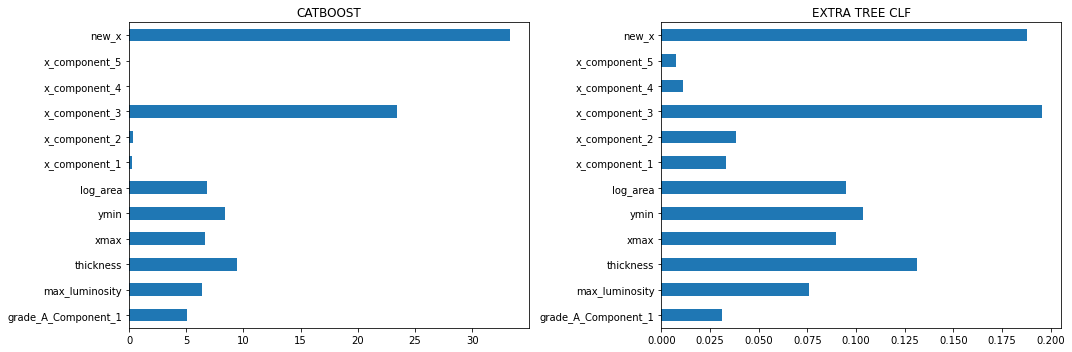

In [524]:
plt.figure(figsize = (15, 5))
plt.subplot(1, 2, 1)
pd.Series(cat.feature_importances_, index = x_train.columns).plot(kind = 'barh', title = 'CATBOOST')
plt.subplot(1, 2, 2)
pd.Series(etc.feature_importances_, index = x_train.columns).plot(kind = 'barh', title = 'EXTRA TREE CLF')
plt.tight_layout()

In [465]:
test.head()

,grade_A_Component_1,max_luminosity,thickness,xmax,ymin,log_area,x_component_1,x_component_2,x_component_3,x_component_4,x_component_5
0,1,123,65,54,1646439,632.391749,0,1,0,0,0
1,0,158,99,132,189874,421.928609,0,0,0,0,0
2,0,120,35,75,12986873,272.212214,1,0,0,0,0
3,0,130,39,177,309634,3312.310581,0,0,1,0,0
4,1,142,75,79,5368307,862.499179,0,0,0,0,0


In [525]:
test['new_x'] = test[['x_component_1', 'x_component_2', 'x_component_4', 'x_component_5']].sum(axis = 1)/4
test = pd.DataFrame(scaler.transform(test), columns = cols)
submission = etc.predict_proba(test)[::1]
submission = pd.DataFrame(submission, columns = ['1', '2'])
submission.head()

SUBMISSION.iloc[:, :] = submission.values
SUBMISSION

SUBMISSION.to_excel('VIF_robust_scaler_smote_newX_excess_removal_comp_ETC.xlsx', index = False)